In [1]:
###############################################################
# run_stochastic_full.jl                                      #
#  – loads JSON files (with BIG sentinel)                     #
#  – builds deterministic-equivalent stochastic MIP           #
#  – solves it with Gurobi                                    #
###############################################################
using JSON3
using JuMP, Gurobi
using Statistics, Random, Printf

const BIG = 1e15                    # must match Python sentinel

##############################
# 1. Read & decode JSON      #
##############################
function read_json_decoded(path)
    raw = JSON3.read(open(path,"r"), Dict)

    function decode(x)
        if x isa Dict
            out = Dict{Any,Any}()
            for (k,v) in x
                key = occursin('§', k) ? Tuple(split(k,'§')) : k
                out[key] = decode(v)
            end
            return out
        elseif x isa Vector
            return [decode(y) for y in x]
        elseif x isa Number && x ≥ BIG-1
            return Inf
        else
            return x
        end
    end

    return decode(raw)
end

sets   = read_json_decoded("inputs_opti/sets.json")
params = read_json_decoded("inputs_opti/params.json")

Dict{Any, Any} with 9 entries:
  "h_i"               => Dict{Any, Any}("W11"=>1287.36, "W64"=>1487.44, "W65"=>…
  "prob_s"            => Dict{Any, Any}("AL061935"=>0.05, "AL112009"=>0.05, "AL…
  "path_edges_ij"     => Dict{Any, Any}(("W5", "CL26")=>[[5066, 6516, 0], [6516…
  "demand_j"          => Dict{Any, Any}("CL20"=>28.9756, "CL5"=>1100.66, "CL13"…
  "disrupted_edges_s" => Dict{Any, Any}("AL061935"=>[[7302, 7083, 0], [25287, 2…
  "c_ij_base"         => Dict{Any, Any}(("W5", "CL26")=>85.3933, ("W40", "CL27"…
  "a_ij_s"            => Dict{Any, Any}("AL061935"=>Dict{Any, Any}(("W5", "CL26…
  "c_ij_s"            => Dict{Any, Any}("AL061935"=>Dict{Any, Any}(("W5", "CL26…
  "rho_i_s"           => Dict{Any, Any}("AL061935"=>Dict{Any, Any}("W11"=>1, "W…

In [2]:
##############################
# 2. Basic sets & scalars    #
##############################
I_N = sets["I_N"]::Vector{String}
J   = sets["J"]::Vector{String}
S   = sets["S"]::Vector{String}

prob_s   = Dict{String,Float64}(params["prob_s"])
demand_j = Dict{String,Float64}(params["demand_j"])
h_i      = Dict{String,Float64}(params["h_i"])

Dict{String, Float64} with 100 entries:
  "W11" => 1287.36
  "W64" => 1487.44
  "W65" => 1479.81
  "W79" => 1143.31
  "W36" => 1488.45
  "W87" => 1233.82
  "W92" => 1456.49
  "W91" => 1000.0
  "W52" => 1354.16
  "W25" => 1000.0
  "W51" => 1493.52
  "W62" => 1088.6
  "W76" => 1000.0
  "W68" => 1000.0
  "W54" => 1000.0
  "W3"  => 1491.91
  "W96" => 1480.77
  "W85" => 1414.82
  "W1"  => 1483.47
  "W57" => 1299.64
  "W77" => 1467.21
  "W24" => 1375.11
  "W88" => 1330.71
  "W21" => 1470.58
  "W45" => 1331.95
  ⋮     => ⋮

In [3]:
##############################
# 3. Pair-key nested dicts   #
##############################
function cast_pairdict(raw::Dict, ::Type{T}) where T
    out = Dict{String,Dict{Tuple{String,String},T}}()
    for (s, inner) in raw
        inner2 = Dict{Tuple{String,String},T}()
        for (k,v) in inner
            inner2[k] = convert(T, v)
        end
        out[s] = inner2
    end
    return out
end

c_ij_s = cast_pairdict(params["c_ij_s"], Float64)
c_ij_base = params["c_ij_base"]
a_ij_s = cast_pairdict(params["a_ij_s"], Int)
rho_i_s= Dict{String,Dict{String,Float64}}(params["rho_i_s"])

Dict{String, Dict{String, Float64}} with 20 entries:
  "AL061935" => Dict("W11"=>1.0, "W64"=>1.0, "W65"=>1.0, "W79"=>1.0, "W36"=>1.0…
  "AL112009" => Dict("W11"=>1.0, "W64"=>1.0, "W65"=>1.0, "W79"=>0.70742, "W36"=…
  "AL072012" => Dict("W11"=>1.0, "W64"=>0.592, "W65"=>0.517829, "W79"=>1.0, "W3…
  "AL011909" => Dict("W11"=>1.0, "W64"=>1.0, "W65"=>1.0, "W79"=>0.455254, "W36"…
  "AL062007" => Dict("W11"=>1.0, "W64"=>0.433439, "W65"=>0.634867, "W79"=>1.0, …
  "AL152001" => Dict("W11"=>1.0, "W64"=>0.571189, "W65"=>0.757173, "W79"=>1.0, …
  "AL092001" => Dict("W11"=>1.0, "W64"=>1.0, "W65"=>1.0, "W79"=>1.0, "W36"=>1.0…
  "AL162017" => Dict("W11"=>0.791007, "W64"=>1.0, "W65"=>1.0, "W79"=>1.0, "W36"…
  "AL022013" => Dict("W11"=>1.0, "W64"=>1.0, "W65"=>1.0, "W79"=>1.0, "W36"=>1.0…
  "AL061940" => Dict("W11"=>1.0, "W64"=>1.0, "W65"=>1.0, "W79"=>0.466777, "W36"…
  "AL041890" => Dict("W11"=>1.0, "W64"=>1.0, "W65"=>1.0, "W79"=>1.0, "W36"=>1.0…
  "AL151916" => Dict("W11"=>1.0, "W64"=>1.0, "W65"=>1.0,

In [4]:
##############################
# 4. Synthetic completions   #
##############################
Random.seed!(123)

C_i        = Dict(i => 2000.0 + 500.0*rand() for i in I_N)  # capacity if built
c_r        = 1.0                                            # unit stock cost
B_facilities = 30000 # 0.15 * sum(h_i[i] for i in I_N)
B_stock      = 20000 #0.50 * sum(C_i[i] for i in I_N) * c_r

# -------------------------------------------
# Deterministic demand  d_j^s  (same for all s)
# -------------------------------------------
d_js = Dict{String,Dict{String,Float64}}()
for s in S
    d_js[s] = demand_j          # reference to the same Dict
end

BigM = 1.2 * sum(demand_j[j] for j in J)

println("Synthetic constants:")
@printf("  B_facilities = %.1f\n", B_facilities)
@printf("  B_stock      = %.1f\n", B_stock)
@printf("  BigM         = %.1f\n\n", BigM)

Synthetic constants:
  B_facilities = 30000.0
  B_stock      = 20000.0
  BigM         = 17634.7



In [5]:
# println("\n===========  Nonzero Shipments  ===========")
# nonzero_x = []

# for s in S, j in J, i in I_N
#     if haskey(x, (i, j, s)) && value(x[i, j, s]) > 1e-3
#         push!(nonzero_x, (scenario=s, from=i, to=j, quantity=value(x[i, j, s])))
#     end
# end

# # Sort and print
# for shipment in sort(nonzero_x, by = x -> -x.quantity)
#     @printf("Scenario %-10s | %s → %s : %.1f\n", shipment.scenario, shipment.from, shipment.to, shipment.quantity)
# end

# println("Total nonzero shipments: ", length(nonzero_x))

In [40]:
# ##############################
# # 1. Packages & helper sets  #
# ##############################
# using JuMP, Gurobi, Printf

# # Finite-cost edge list per scenario
# valid_edges_s = Dict{String,Vector{Tuple{String,String}}}()
# for s in S
#     valid_edges_s[s] = [ (i,j) for (i,j) in keys(c_ij_s[s])
#                          if isfinite(c_ij_s[s][(i,j)]) ]
# end

# ########################################
# # 2.  Full disruption-aware model (MIP)#
# ########################################
# model = Model(Gurobi.Optimizer)
# set_optimizer_attribute(model, "OutputFlag", 1)

# # First-stage
# @variable(model, f[i in I_N], Bin)
# @variable(model, r[i in I_N] ≥ 0)

# # Second-stage
# @variable(model,
#           x[i in I_N, j in J, s in S; (i,j) in valid_edges_s[s]] ≥ 0)
# @variable(model, u[j in J, s in S] ≥ 0)

# @objective(model, Min,
#     sum(h_i[i]*f[i]                  for i in I_N) +
#     c_r * sum(r[i]                   for i in I_N) +
#     sum(prob_s[s] * (
#         sum(c_ij_s[s][(i,j)] * x[i,j,s]   for (i,j) in valid_edges_s[s]) +
#         BigM * sum(u[j,s] for j in J)
#     ) for s in S)
# )

# # Constraints
# @constraint(model, [i in I_N], r[i] ≤ C_i[i]*f[i])                    # open→stock
# @constraint(model,
#     [i in I_N, s in S],
#     sum(x[i,j,s] for (j) in (j for (ii,j) in valid_edges_s[s] if ii==i)) ≤
#         rho_i_s[s][i] * r[i])                                         # survival
# @constraint(model,
#     [j in J, s in S],
#     sum(x[i,j,s] for (i) in (i for (i,jj) in valid_edges_s[s] if jj==j)) + u[j,s]
#         ≥ demand_j[j])                                                # demand
# @constraint(model,
#     [i in I_N, j in J, s in S; (i,j) in valid_edges_s[s]],
#     x[i,j,s] ≤ a_ij_s[s][(i,j)] * BigM)                               # disruption
# @constraint(model,
#     sum(h_i[i]*f[i] for i in I_N) ≤ B_facilities)                     # budgets
# @constraint(model,
#     c_r * sum(r[i] for i in I_N) ≤ B_stock)

# println("Optimizing full stochastic model …")
# optimize!(model)

# f_star = Dict(i => value(f[i]) for i in I_N)
# r_star = Dict(i => value(r[i]) for i in I_N)

# #############################################
# # 3.  Deterministic baseline (no disruption)#
# #############################################
# # Helper: finite base edges
# valid_edges_base = [ (i,j) for (i,j) in keys(c_ij_base)
#                      if isfinite(c_ij_base[(i,j)]) ]

# model_det = Model(Gurobi.Optimizer)
# set_optimizer_attribute(model_det, "OutputFlag", 0)

# @variable(model_det, fB[i in I_N], Bin)
# @variable(model_det, rB[i in I_N] ≥ 0)
# @variable(model_det, xB[i in I_N, j in J; (i,j) in valid_edges_base] ≥ 0)
# @variable(model_det, uB[j in J] ≥ 0)

# @objective(model_det, Min,
#       sum(h_i[i]*fB[i]               for i in I_N) +
#       c_r * sum(rB[i]                for i in I_N) +
#       sum(c_ij_base[(i,j)] * xB[i,j] for (i,j) in valid_edges_base) +
#       BigM * sum(uB[j]               for j in J)
# )
# @constraint(model_det, [i in I_N], rB[i] ≤ C_i[i]*fB[i])
# @constraint(model_det, [i in I_N],
#     sum(xB[i,j] for j in J if (i,j) in valid_edges_base) ≤ rB[i])
# @constraint(model_det, [j in J],
#     sum(xB[i,j] for i in I_N if (i,j) in valid_edges_base) + uB[j] ≥ demand_j[j])
# @constraint(model_det, sum(h_i[i]*fB[i] for i in I_N) ≤ B_facilities)
# @constraint(model_det, c_r * sum(rB[i] for i in I_N)  ≤ B_stock)

# println("Optimizing deterministic baseline …")
# optimize!(model_det)

# f_base = Dict(i => value(fB[i]) for i in I_N)
# r_base = Dict(i => value(rB[i]) for i in I_N)

# ######################################################
# # 4.  Generic evaluator: compute_actual_cost(f,r)    #
# ######################################################
# function compute_actual_cost(f_sol::Dict{String,Float64},
#                              r_sol::Dict{String,Float64};
#                              verbose::Bool=false)

#     # 1st-stage cost
#     cost_first = sum(h_i[i]*f_sol[i] for i in I_N) +
#                  c_r * sum(r_sol[i]  for i in I_N)

#     exp_ship    = 0.0   # expected shipping cost
#     exp_unmet   = 0.0   # expected unmet‐penalty cost

#     # per‐scenario breakdown
#     scenario_ship       = Dict{String,Float64}()
#     scenario_unmet_qty  = Dict{String,Float64}()
#     scenario_unmet_cost = Dict{String,Float64}()

#     for s in S
#         edges = valid_edges_s[s]

#         sub = Model(Gurobi.Optimizer)
#         set_optimizer_attribute(sub, "OutputFlag", 0)

#         @variable(sub, x[i in I_N, j in J; (i,j) in edges] ≥ 0)
#         @variable(sub, u[j in J] ≥ 0)

#         @objective(sub, Min,
#             sum(c_ij_s[s][(i,j)] * x[i,j]    for (i,j) in edges) +
#             BigM * sum(u[j]                  for j in J)
#         )

#         @constraint(sub, [i in I_N],
#             sum(x[i,j] for j in J if (i,j) in edges) ≤
#                 rho_i_s[s][i] * get(r_sol,i,0.0) )
#         @constraint(sub, [j in J],
#             sum(x[i,j] for i in I_N if (i,j) in edges) + u[j] ≥ demand_j[j])
#         @constraint(sub,
#             [i in I_N, j in J; (i,j) in edges],
#             x[i,j] ≤ a_ij_s[s][(i,j)] * BigM)

#         optimize!(sub)

#         # extract scenario results
#         scen_ship_cost  = sum(value(x[i,j]) * c_ij_s[s][(i,j)]
#                               for (i,j) in edges)
#         scen_unmet_qty  = sum(value(u[j]) for j in J)
#         scen_unmet_cost = BigM * scen_unmet_qty

#         # accumulate expectations
#         exp_ship  += prob_s[s] * scen_ship_cost
#         exp_unmet += prob_s[s] * scen_unmet_cost

#         scenario_ship[s]       = scen_ship_cost
#         scenario_unmet_qty[s]  = scen_unmet_qty
#         scenario_unmet_cost[s] = scen_unmet_cost
#     end

#     if verbose
#         println("\n— Scenario shipping vs unmet quantity —")
#         for (s, ship_cost) in sort(collect(scenario_ship),
#                                     by=x->x[2], rev=true)
#             qty = scenario_unmet_qty[s]
#             @printf("Scenario %-12s → ship = %10.2f   unmet_qty = %6.1f\n",
#                     s, ship_cost, qty)
#         end
#     end

#     total = cost_first + exp_ship + exp_unmet
#     return total, cost_first, exp_ship, exp_unmet,
#            scenario_ship, scenario_unmet_qty, scenario_unmet_cost
# end



# #########################################
# # 5.  Evaluate both solutions & display #
# #########################################
# tot_star, first_star, ship_star, unmet_cost_star,
# scen_ship, scen_unmet_qty, scen_unmet_cost =
#     compute_actual_cost(f_star, r_star; verbose=true)

# tot_base, first_base, ship_base, unmet_cost_base,
# _, scen_unmet_qty_base, _ =
#     compute_actual_cost(f_base, r_base; verbose=true)


# println("\n================  RESULTS  ================")
# @printf("%-20s  %10s  %10s  %10s  %10s\n",
#         "", "TOTAL", "1st-stage", "ExpShip", "ExpUnmet")
# @printf("%-20s  %10.2f  %10.2f  %10.2f  %10.2f\n",
#         "Optimal (Benders)", tot_star, first_star, ship_star, unmet_cost_star)
# @printf("%-20s  %10.2f  %10.2f  %10.2f  %10.2f\n",
#         "Baseline (no hur.)", tot_base, first_base, ship_base, unmet_cost_base)
# println("===========================================\n")


In [43]:
##############################
# 1. Packages & helper sets  #
##############################
using JuMP, Gurobi, Printf

valid_edges_s = Dict{String,Vector{Tuple{String,String}}}()
for s in S
    valid_edges_s[s] = [(i,j) for (i,j) in keys(c_ij_s[s]) if isfinite(c_ij_s[s][(i,j)])]
end
valid_edges_base = [(i,j) for (i,j) in keys(c_ij_base) if isfinite(c_ij_base[(i,j)])]

############################################################
# 2. Full disruption-aware model
############################################################
model = Model(Gurobi.Optimizer); set_optimizer_attribute(model,"OutputFlag",1)

@variable(model, f[i in I_N], Bin)
@variable(model, r[i in I_N] ≥ 0)
@variable(model, x[i in I_N, j in J, s in S; (i,j) in valid_edges_s[s]] ≥ 0)
@variable(model, u[j in J, s in S] ≥ 0)

@objective(model, Min,
    sum(h_i[i]*f[i] for i in I_N) +
    c_r*sum(r[i] for i in I_N) +
    sum(prob_s[s] * (
        sum(c_ij_s[s][(i,j)]*x[i,j,s] for (i,j) in valid_edges_s[s]) +
        BigM*sum(u[j,s] for j in J)
    ) for s in S)
)

@constraint(model, [i in I_N], r[i] ≤ C_i[i]*f[i])
@constraint(model, [i in I_N, s in S],
    sum(x[i,j,s] for (j) in (j for (ii,j) in valid_edges_s[s] if ii==i)) ≤
        rho_i_s[s][i]*r[i])
@constraint(model, [j in J, s in S],
    sum(x[i,j,s] for (i) in (i for (i,jj) in valid_edges_s[s] if jj==j)) + u[j,s] ≥ demand_j[j])
@constraint(model, [i in I_N, j in J, s in S; (i,j) in valid_edges_s[s]],
    x[i,j,s] ≤ a_ij_s[s][(i,j)]*BigM)
@constraint(model, sum(h_i[i]*f[i] for i in I_N) ≤ B_facilities)
@constraint(model, c_r*sum(r[i] for i in I_N) ≤ B_stock)

println("→ Solving stochastic model …")
elapsed_time = @elapsed optimize!(model)
@printf("✓ Solve time: %.2f seconds\n", elapsed_time)
f_star = Dict(i => value(f[i]) for i in I_N)
r_star = Dict(i => value(r[i]) for i in I_N)

############################################################
# 3. Deterministic baseline
############################################################
model_det = Model(Gurobi.Optimizer); set_optimizer_attribute(model_det,"OutputFlag",0)

@variable(model_det, fB[i in I_N], Bin)
@variable(model_det, rB[i in I_N] ≥ 0)
@variable(model_det, xB[i in I_N, j in J; (i,j) in valid_edges_base] ≥ 0)
@variable(model_det, uB[j in J] ≥ 0)

@objective(model_det, Min,
    sum(h_i[i]*fB[i] for i in I_N) +
    c_r*sum(rB[i] for i in I_N) +
    sum(c_ij_base[(i,j)]*xB[i,j] for (i,j) in valid_edges_base) +
    BigM*sum(uB[j] for j in J)
)
@constraint(model_det, [i in I_N], rB[i] ≤ C_i[i]*fB[i])
@constraint(model_det, [i in I_N],
    sum(xB[i,j] for j in J if (i,j) in valid_edges_base) ≤ rB[i])
@constraint(model_det, [j in J],
    sum(xB[i,j] for i in I_N if (i,j) in valid_edges_base) + uB[j] ≥ demand_j[j])
@constraint(model_det, sum(h_i[i]*fB[i] for i in I_N) ≤ B_facilities)
@constraint(model_det, c_r*sum(rB[i] for i in I_N) ≤ B_stock)

println("→ solving deterministic baseline …"); optimize!(model_det)
f_base = Dict(i => value(fB[i]) for i in I_N)
r_base = Dict(i => value(rB[i]) for i in I_N)

############################################################
# 4. Evaluator (returns node-level unmet per scenario)
############################################################
function compute_actual_cost(f_sol::Dict{String,Float64},
                             r_sol::Dict{String,Float64};
                             verbose=false)

    first = sum(h_i[i]*f_sol[i] for i in I_N) +
            c_r*sum(r_sol[i] for i in I_N)

    exp_ship = 0.0; exp_unmet = 0.0
    scen_ship = Dict{String,Float64}()
    scen_unmet_total = Dict{String,Float64}()
    scen_unmet_dict  = Dict{String,Dict{String,Float64}}()

    for s in S
        edges = valid_edges_s[s]
        sub = Model(Gurobi.Optimizer); set_optimizer_attribute(sub,"OutputFlag",0)

        @variable(sub, x[i in I_N, j in J; (i,j) in edges] ≥ 0)
        @variable(sub, u[j in J] ≥ 0)

        @objective(sub, Min,
            sum(c_ij_s[s][(i,j)]*x[i,j] for (i,j) in edges) +
            BigM*sum(u[j] for j in J)
        )
        @constraint(sub,[i in I_N],
            sum(x[i,j] for j in J if (i,j) in edges) ≤ rho_i_s[s][i]*get(r_sol,i,0.0))
        @constraint(sub,[j in J],
            sum(x[i,j] for i in I_N if (i,j) in edges) + u[j] ≥ demand_j[j])
        @constraint(sub,[i in I_N, j in J; (i,j) in edges],
            x[i,j] ≤ a_ij_s[s][(i,j)]*BigM)

        optimize!(sub)

        ship_cost = sum(value(x[i,j])*c_ij_s[s][(i,j)] for (i,j) in edges)
        unmet_dict = Dict(j=>value(u[j]) for j in J)
        unmet_qty  = sum(values(unmet_dict))
        unmet_cost = BigM*unmet_qty

        exp_ship  += prob_s[s]*ship_cost
        exp_unmet += prob_s[s]*unmet_cost
        scen_ship[s]        = ship_cost
        scen_unmet_total[s] = unmet_qty
        scen_unmet_dict[s]  = unmet_dict
    end

    if verbose
        println("\n— Scenario shipping vs unmet qty —")
        for (s,c) in sort(collect(scen_ship), by=x->x[2], rev=true)
            @printf("Scenario %-12s → ship=%9.2f  unmet=%7.2f\n", s, c, scen_unmet_total[s])
        end
    end

    total = first + exp_ship + exp_unmet
    return total, first, exp_ship, exp_unmet,
           scen_unmet_total, scen_unmet_dict
end

############################################################
# 5. Evaluate both solutions
############################################################
tot_star, first_star, ship_star, unmet_cost_star,
    scen_unmet_tot_opt, scen_unmet_dict_opt =
    compute_actual_cost(f_star, r_star; verbose=true)

tot_base, first_base, ship_base, unmet_cost_base,
    scen_unmet_tot_base, scen_unmet_dict_base =
    compute_actual_cost(f_base, r_base; verbose=true)

println("\n================  RESULTS  ================")
@printf("%-18s %10s %10s %10s %10s\n","", "TOTAL","1st","Ship","Unmet")
@printf("%-18s %10.2f %10.2f %10.2f %10.2f\n",
        "Optimal",  tot_star,  first_star,  ship_star,  unmet_cost_star)
@printf("%-18s %10.2f %10.2f %10.2f %10.2f\n",
        "Baseline", tot_base,  first_base,  ship_base,  unmet_cost_base)
println("===========================================\n")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter OutputFlag to value 1
→ Solving stochastic model …
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[x86] - Darwin 23.6.0 23G93)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 29980 rows, 28078 columns and 84914 nonzeros
Model fingerprint: 0x564f69bd
Variable types: 27978 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [2e-01, 2e+03]
  Objective range  [8e-03, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+04]
Found heuristic solution: objective 2.591509e+08
Presolve removed 27964 rows and 81 columns
Presolve time: 0.10s
Presolved: 2016 rows, 27997 columns, 56877 nonzeros
Variable types: 27920 continuous, 77 integer (77 binary)

Root relaxation: objective 3.552182e+06, 2103 iterati

## Benders Decomposition for the Disruption-Aware Warehouse Model

## 1. Two-Stage Stochastic Model

1. **First stage**
   Decide which warehouses to open and how much inventory to pre-position:

   $$
     \min_{f\in\{0,1\}^{I_N},\,r\ge0}\;
       \sum_{i}h_i\,f_i \;+\;c_r\sum_i r_i
       \;+\;\sum_{s\in S}\pi_s\,Q_s(r)
     \quad\text{s.t. }r_i\le C_i\,f_i\;\forall i.
   $$

2. **Second stage** (scenario $s$)
   Given $r^*$, solve

   $$
   \begin{aligned}
     Q_s(r^*) = \min_{x\ge0,\;u\ge0}\;&
       \sum_{(i,j)\in E_s}c^s_{ij}\,x_{ij}
       \;+\;M\sum_j u_j\\[-0.5em]
     \text{s.t.}\quad
       &\sum_{j:(i,j)\in E_s}x_{ij}
         \;\le\;\rho^s_i\,r^*_i
       &&\forall i,\\
       &\sum_{i:(i,j)\in E_s}x_{ij} + u_j
         \;\ge\;d_j
       &&\forall j,\\
       &x_{ij}\;\le\;M\,a^s_{ij}
       &&\forall (i,j)\in E_s.
   \end{aligned}
   $$

---

## 2. Exact Dual of the Subproblem

Write each row in the canonical “$\ge0$” form by moving all variables to the left:

| Primal row                       | “$\ge0$” form                        | dual var      | sign              |
| -------------------------------- | ------------------------------------ | ------------- | ----------------- |
| $\sum_j x_{ij}\le\rho^s_i r^*_i$ | $\;\rho^s_i r^*_i-\sum_j x_{ij}\ge0$ | $\alpha_i$    | $\alpha_i\ge0$    |
| $\sum_i x_{ij}+u_j\ge d_j$       | $\sum_i x_{ij}+u_j-d_j\ge0$          | $\beta_j$     | $\beta_j\ge0$     |
| $x_{ij}\le M\,a^s_{ij}$          | $\;M\,a^s_{ij}-x_{ij}\ge0$           | $\gamma_{ij}$ | $\gamma_{ij}\ge0$ |

Then by standard LP duality (max $p^T b$ subject to sign and coefficient constraints) one obtains:

$$
\boxed{
\begin{aligned}
\max_{\substack{\alpha\ge0,\;\beta\ge0,\;\gamma\ge0}}
\;&
\sum_{i\in I_N}\alpha_i\,\bigl(-\,\rho^s_i\,r^*_i\bigr)
\;+\;\sum_{j\in J}\beta_j\,d_j
\;+\;\sum_{(i,j)\in E_s}\gamma_{ij}\,\bigl(-\,M\,a^s_{ij}\bigr)
\\[-0.3em]
\text{s.t.}\quad
& 
\underbrace{-\alpha_i}_{\substack{\text{from row (i)}}}
\;+\;\underbrace{\beta_j}_{\substack{\text{from row (j)}}}
\;-\;\underbrace{\gamma_{ij}}_{\substack{\text{from row (i,j)}}}
\;\le\;c^s_{ij},
\quad\forall (i,j)\in E_s,
\\
& \beta_j \;\le\;M,\quad\forall j\in J.
\end{aligned}
}
$$

> **Notes on signs**
>
> * Each “$\ge0$” row in the primal gives a nonnegative dual.
> * The constant term $b$ for row $i$ is $\rho^s_i\,r^*_i$, but because we *moved* it to the left as $\rho^s_i r^*_i - \sum x\ge0$, in the dual objective it appears as $\alpha_i\cdot(-\rho^s_i r^*_i)$.
> * Similarly for the $x_{ij}\le M\,a^s_{ij}$ row we moved $M\,a^s_{ij}$ left and get $\gamma_{ij}\cdot(-M\,a^s_{ij})$.
> * The demand row yields $+\,\beta_j\,d_j$.

By strong duality its optimum equals $Q_s(r^*)$.

---

## 3. Benders Optimality Cut

Let $(\alpha^*,\beta^*,\gamma^*)$ be an optimal dual solution at $r^*$.  Then

$$
Q_s(r^*) 
= \sum_i\alpha^*_i\bigl(-\rho^s_i\,r^*_i\bigr)
  +\sum_j\beta^*_j\,d_j
  +\sum_{(i,j)}\gamma^*_{ij}\bigl(-M\,a^s_{ij}\bigr).
$$

Re-arrange to isolate the terms that multiply $r^*$:

$$
Q_s(r^*)
= C_s \;+\;\sum_{i\in I_N}
               \underbrace{\bigl(-\alpha^*_i\,\rho^s_i\bigr)}_{\ge0}\,r^*_i,
$$

where

$$
C_s 
:= Q_s(r^*)
  \;-\;\sum_i\bigl(-\alpha^*_i\,\rho^s_i\bigr)\,r^*_i
  \;=\;
  \sum_j\beta^*_j\,d_j
  +\sum_{(i,j)}\gamma^*_{ij}\bigl(-M\,a^s_{ij}\bigr).
$$

Since $Q_s(r)$ is convex in $r$, the supporting hyperplane at $r^*$ gives the valid cut

$$
\boxed{
\theta_s \;\ge\;
  C_s
  \;+\;\sum_{i\in I_N}\bigl(-\alpha^*_i\,\rho^s_i\bigr)\,r_i
}
\quad\forall s\in S,
$$

and each coefficient $-\alpha^*_i\,\rho^s_i\ge0$ as required.

---

## 4. Multi-Cut Benders Algorithm

```text
Initialize MP with variables f_i∈{0,1}, r_i≥0, θ_s≥0 and no cuts.

repeat
  1) Solve MP ⇒ (f*,r*,θ*), let LB = obj(MP).
  2) Compute first‐stage cost F = ∑h_i f*_i + c_r∑r*_i.
     Set UB_cand ← F.
  3) For each scenario s:
       ▶ Solve SP_s(r*) and its dual ⇒ get Q_s, (α*,β*,γ*)
       ▶ UB_cand += π_s · Q_s
       ▶ Form C_s = Q_s − ∑_i (−α*_i ρ^s_i) r*_i
       ▶ Add cut to MP: θ_s ≥ C_s + ∑_i (−α*_i ρ^s_i)·r_i
  4) Update UB ← min(UB, UB_cand).
until (UB − LB)/max(1,|LB|) ≤ tolerance

Return the Benders‐optimal first‐stage \((f^*,r^*)\).
```

Every dual coefficient and constant now matches *exactly* the form you posted.

In [44]:
##############################################################################
# 0.  Packages & input data (assumed already in memory)
##############################################################################
using JuMP, Gurobi, Printf, Statistics
using Plots, CSV, DataFrames, Dates      # Dates for wall-clock timers

mkpath("output")                         # make sure output/ exists

# ---------------------------------------------------------------------------
# helper: finite-cost edges per scenario
# ---------------------------------------------------------------------------
valid_edges_s = Dict{String,Vector{Tuple{String,String}}}()
for s in S
    valid_edges_s[s] = [(i,j) for (i,j) in keys(c_ij_s[s]) if isfinite(c_ij_s[s][(i,j)])]
end

##############################################################################
# 1.  Benders master problem (MP)
##############################################################################
MP = Model(Gurobi.Optimizer)
set_optimizer_attribute(MP, "OutputFlag", 0)

@variable(MP, f[i in I_N], Bin)
@variable(MP, r[i in I_N] ≥ 0)
@variable(MP, θ[s in S]   ≥ 0)

@objective(MP, Min,
    sum(h_i[i]*f[i] for i in I_N) +
    c_r*sum(r[i]    for i in I_N) +
    sum(prob_s[s]*θ[s] for s in S))

@constraint(MP, [i in I_N], r[i] ≤ C_i[i]*f[i])
@constraint(MP, sum(h_i[i]*f[i] for i in I_N) ≤ B_facilities)
@constraint(MP, c_r*sum(r[i]    for i in I_N) ≤ B_stock)

##############################################################################
# 2.  Multi-cut Benders loop with timing
##############################################################################
const GAP_TOL  = 1e-2
const MAX_ITER = 200

LB_hist = Float64[]; UB_hist = Float64[]
mp_secs = Float64[]; sp_secs = Float64[]
UB_best = Inf

println("\n===========  Benders for disruption-aware model (serial SP)  ===========")
global_start = time()      # wall-clock reference (seconds)

for iter in 1:MAX_ITER
    # -- Master -------------------------------------------------------------
    push!(mp_secs, @elapsed optimize!(MP))
    LB = objective_value(MP); push!(LB_hist, LB)
    f_val = value.(f);  r_val = value.(r)

    # -- Sub-problems -------------------------------------------------------
    sp_elapsed = @elapsed begin
        UB_candidate = sum(h_i[i]*f_val[i] for i in I_N) +
                       c_r*sum(r_val[i]    for i in I_N)

        for s in S
            edges = valid_edges_s[s]
            SP = Model(Gurobi.Optimizer); set_optimizer_attribute(SP,"OutputFlag",0)

            @variable(SP, x[i in I_N, j in J; (i,j) in edges] ≥ 0)
            @variable(SP, u[j in J] ≥ 0)

            @objective(SP, Min,
                sum(c_ij_s[s][(i,j)]*x[i,j] for (i,j) in edges) +
                BigM*sum(u[j] for j in J))

            sup = @constraint(SP, [i in I_N],
                  rho_i_s[s][i]*r_val[i] - sum(x[i,j] for j in J if (i,j) in edges) ≥ 0)

            @constraint(SP, [j in J],
                  sum(x[i,j] for i in I_N if (i,j) in edges) + u[j] - demand_j[j] ≥ 0)

            @constraint(SP, [(i,j) in edges],
                  a_ij_s[s][(i,j)]*BigM - x[i,j] ≥ 0)

            optimize!(SP)

            α   = dual.(sup)
            Q_s = objective_value(SP)
            UB_candidate += prob_s[s]*Q_s
            C_s = Q_s + sum(α[i]*rho_i_s[s][i]*r_val[i] for i in I_N)

            @constraint(MP,
                θ[s] ≥ C_s - sum(α[i]*rho_i_s[s][i]*r[i] for i in I_N))
        end
    end
    push!(sp_secs, sp_elapsed)

    # -- Update & print -----------------------------------------------------
    UB_best = min(UB_best, UB_candidate)
    push!(UB_hist, UB_best)
    rel_gap = (UB_best - LB) / max(abs(LB), 1.0)

    @printf("iter=%3d  LB=%10.2f  UB=%10.2f  gap=%8.2e  |  MP %.2fs  SP %.2fs\n",
            iter, LB, UB_best, rel_gap, mp_secs[end], sp_secs[end])

    rel_gap ≤ GAP_TOL && (println("→ Converged."); break)
end

# ── Runtime summary ---------------------------------------------------------
total_mp = sum(mp_secs)
total_sp = sum(sp_secs)
overall  = time() - global_start

println("\nTotal MP time : ", round(total_mp, digits=2), " s")
println("Total SP time : ", round(total_sp, digits=2), " s")
println("Overall time  : ", round(overall,  digits=2), " s")

# final solve for clean solution
optimize!(MP)

##############################################################################
# 3.  Summary
##############################################################################
println("\n===========  Benders summary  ===========")
println("Iterations       : ", length(LB_hist))
println("Final LB         : ", LB_hist[end])
println("Best UB          : ", UB_hist[end])
println("Built warehouses : ",
        join([i for i in I_N if value(f[i]) > 0.5], ", "))
println("Inventory levels : ",
        join(["$i=$(round(value(r[i]),digits=1))"
              for i in I_N if value(r[i]) > 1e-3], ", "))
println("========================================\n")

##############################################################################
# 4.  Save convergence + timing
##############################################################################
df = DataFrame(iter = 1:length(LB_hist),
               LB   = LB_hist,
               UB   = UB_hist,
               MP_s = mp_secs,
               SP_s = sp_secs)
CSV.write("output/convergence.csv", df)
println("✓ Convergence & timing data saved to output/convergence.csv")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18

===========  Benders for disruption-aware model (serial SP)  ===========
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Us

In [45]:
LB_hist .+= 1e-7
UB_hist .+= 1e-7

# plot convergence
plot(1:length(LB_hist), LB_hist, label="LB", lw=2, yscale = :log10)
plot!(1:length(UB_hist), UB_hist, label="UB", lw=2, linestyle=:dash, yscale = :log10)
xlabel!("Benders Iteration")
ylabel!("Objective value")
title!("Master LB vs. Incumbent UB")
savefig("output/convergence.png")
println("✓ Convergence plot saved in output/convergence.png")


✓ Convergence plot saved in output/convergence.png


In [46]:
##############################################################################
# 2.  Multi-cut Benders loop – sub-problems solved in parallel (timed)
##############################################################################
const GAP_TOL  = 1e-2
const MAX_ITER = 200

LB_hist, UB_hist = Float64[], Float64[]
mp_secs, sp_secs = Float64[], Float64[]
UB_best = Inf

println("\n===========  Benders (parallel SP)  ===========")
println("Threads available = ", Threads.nthreads())

overall_start = time()   # ── total wall-clock timer ─────────────────────────

for iter in 1:MAX_ITER
    # 1) ── Master solve ───────────────────────────────────────────────────
    push!(mp_secs, @elapsed optimize!(MP))
    LB = objective_value(MP)
    push!(LB_hist, LB)

    f_val = value.(f)
    r_val = value.(r)

    # 2) ── Sub-problems (parallel) ───────────────────────────────────────
    nS   = length(S)
    Q    = zeros(Float64, nS)
    αmat = Vector{Any}(undef, nS)

    sp_time = @elapsed Threads.@threads for idx in 1:nS
        s     = S[idx]
        edges = valid_edges_s[s]

        SP = Model(Gurobi.Optimizer)
        set_optimizer_attribute(SP, "OutputFlag", 0)

        @variable(SP, x[i in I_N, j in J; (i,j) in edges] ≥ 0)
        @variable(SP, u[j in J] ≥ 0)

        @objective(SP, Min,
            sum(c_ij_s[s][(i,j)]*x[i,j] for (i,j) in edges) +
            BigM*sum(u[j] for j in J))

        sup = @constraint(SP, [i in I_N],
                  rho_i_s[s][i]*r_val[i] -
                  sum(x[i,j] for j in J if (i,j) in edges) ≥ 0)

        @constraint(SP, [j in J],
                  sum(x[i,j] for i in I_N if (i,j) in edges) + u[j] - demand_j[j] ≥ 0)

        @constraint(SP, [(i,j) in edges],
                  a_ij_s[s][(i,j)]*BigM - x[i,j] ≥ 0)

        optimize!(SP)

        Q[idx]     = objective_value(SP)
        αmat[idx]  = dual.(sup)          # DenseAxisArray keyed by facility names
    end
    push!(sp_secs, sp_time)

    # 3) ── Build UB & add cuts (serial) ──────────────────────────────────
    UB_cand = sum(h_i[i]*f_val[i] for i in I_N) +
              c_r*sum(r_val[i]    for i in I_N)

    for (idx,s) in enumerate(S)
        α   = αmat[idx]
        Q_s = Q[idx]

        UB_cand += prob_s[s]*Q_s
        C_s = Q_s + sum(α[i]*rho_i_s[s][i]*r_val[i] for i in I_N)

        @constraint(MP,
            θ[s] ≥ C_s - sum(α[i]*rho_i_s[s][i]*r[i] for i in I_N))
    end

    UB_best = min(UB_best, UB_cand)
    push!(UB_hist, UB_best)

    rel_gap = (UB_best - LB) / max(abs(LB), 1.0)
    @printf("iter=%3d  LB=%10.2f  UB=%10.2f  gap=%8.2e  |  MP %.2fs  SP %.2fs\n",
            iter, LB, UB_best, rel_gap, mp_secs[end], sp_secs[end])

    rel_gap ≤ GAP_TOL && (println("→ Converged."); break)
end

total_time = time() - overall_start      # ── total wall-clock
println("\nTotal MP time : ", round(sum(mp_secs), digits=2), " s")
println("Total SP time : ", round(sum(sp_secs), digits=2), " s")
println("Overall time  : ", round(total_time,     digits=2), " s")


===========  Benders (parallel SP)  ===========
Threads available = 4
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Academic license - for non-commercial use only - expires 2025-11-18
Academic license - for non-commercial use only - expires 2025-11-18
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Usern

In [12]:
################################################################
# 8. Save key results for mapping (Optimal + Baseline)
################################################################
using JSON3, CSV, DataFrames, Dates
mkpath("output")

# 1. warehouses built ------------------------------------------
JSON3.write("output/built_warehouses.json", Dict(
    "built_optimal"  => [i for (i,v) in f_star if v > 0.5],
    "built_baseline" => [i for (i,v) in f_base if v > 0.5],
    "timestamp"      => string(now()),
))

# 2. warehouse-stock CSV  (all candidates) ---------------------
ware_rows = [(ware_id=i,
              r_optimal = get(r_star, i, 0.0),
              r_baseline= get(r_base, i, 0.0)) for i in I_N]
CSV.write("output/warehouse_stock.csv", DataFrame(ware_rows))

# 3. scenario-level unmet CSV ----------------------------------
rows = NamedTuple[]
exp_unmet_opt  = Dict(j=>0.0 for j in J)
exp_unmet_base = Dict(j=>0.0 for j in J)

for s in S, j in J
    uq_opt  = get(scen_unmet_dict_opt[s],  j, 0.0)
    uq_base = get(scen_unmet_dict_base[s], j, 0.0)
    push!(rows,(scenario_id=s,dem_id=j,
                unmet_qty_opt=uq_opt,
                unmet_qty_base=uq_base))
    exp_unmet_opt[j]  += prob_s[s]*uq_opt
    exp_unmet_base[j] += prob_s[s]*uq_base
end
CSV.write("output/demand_unmet.csv", DataFrame(rows))

# 4. node-level expected satisfaction --------------------------
demand_vec = [demand_j[j] for j in J]
sat_opt  = (demand_vec .- [exp_unmet_opt[j]  for j in J]) ./ demand_vec
sat_base = (demand_vec .- [exp_unmet_base[j] for j in J]) ./ demand_vec

CSV.write("output/demand_satisfaction.csv",
    DataFrame(dem_id=J, demand=demand_vec,
              unmet_optimal=[exp_unmet_opt[j] for j in J],
              satisfied_opt=sat_opt,
              unmet_baseline=[exp_unmet_base[j] for j in J],
              satisfied_base=sat_base))

println("✓ Results (built, stock, unmet, satisfaction) saved to output/")


✓ Results (built, stock, unmet, satisfaction) saved to output/


## Global Evaluation experiments

In [33]:
###############################################################################
#  Disaster-Aware Facility-to-Demand Optimization  (clean, self-contained)
###############################################################################
using JuMP, Gurobi, Printf, Statistics

# -----------------------------------------------------------------------------
# 0.  Weight helpers
# -----------------------------------------------------------------------------
equal_probs(s::Vector{String}) = Dict(q => 1.0 / length(s) for q in s)

function linear_weights(s::Vector{String})
    k = length(s)
    w = Float64.(1:k)              # ensure Float64
    w ./= sum(w)
    Dict(s[i] => w[i] for i in eachindex(s))
end

function exponential_weights(s::Vector{String}; λ::Float64 = 0.9)
    k = length(s)
    w = [λ^(k - i) for i in 1:k]   # already Float64
    w ./= sum(w)
    Dict(s[i] => w[i] for i in eachindex(s))
end

# -----------------------------------------------------------------------------
# 1-A.  Disruption-aware optimiser (expected value)
# -----------------------------------------------------------------------------
function solve_disruption_model(
        selS::Vector{String};
        prob_dict::Dict{String,<:Real}=equal_probs(selS),
        verbose::Bool=false)

    prob = Dict(k => float(v) for (k,v) in prob_dict)        # promote weights

    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", verbose ? 1 : 0)

    @variable(model, f[i in I_N], Bin)
    @variable(model, r[i in I_N] ≥ 0)
    @variable(model, x[i in I_N, j in J, s in selS; (i,j) in valid_edges_s[s]] ≥ 0)
    @variable(model, u[j in J, s in selS] ≥ 0)

    @expression(model, scen_cost[s in selS],
        sum(c_ij_s[s][(i,j)] * x[i,j,s] for (i,j) in valid_edges_s[s]) +
        BigM * sum(u[j,s] for j in J))

    @objective(model, Min,
        sum(h_i[i]*f[i] for i in I_N) +
        c_r * sum(r[i]  for i in I_N) +
        sum(prob[s] * scen_cost[s] for s in selS)
    )

    @constraint(model, [i in I_N], r[i] ≤ C_i[i]*f[i])
    @constraint(model, [i in I_N, s in selS],
        sum(x[i,j,s] for j in (j for (ii,j) in valid_edges_s[s] if ii==i)) ≤ rho_i_s[s][i]*r[i])
    @constraint(model, [j in J, s in selS],
        sum(x[i,j,s] for i in (i for (i,jj) in valid_edges_s[s] if jj==j)) + u[j,s] ≥ demand_j[j])
    @constraint(model, [i in I_N, j in J, s in selS; (i,j) in valid_edges_s[s]],
        x[i,j,s] ≤ a_ij_s[s][(i,j)] * BigM)
    @constraint(model, sum(h_i[i]*f[i] for i in I_N) ≤ B_facilities)
    @constraint(model, c_r*sum(r[i] for i in I_N)    ≤ B_stock)

    optimize!(model)
    return Dict(i=>value(f[i]) for i in I_N),
           Dict(i=>value(r[i]) for i in I_N),
           objective_value(model)
end

# -----------------------------------------------------------------------------
# 1-B.  No-disruption baseline
# -----------------------------------------------------------------------------
function solve_no_disruption(; verbose=false)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", verbose ? 1 : 0)

    @variable(model, f[i in I_N], Bin)
    @variable(model, r[i in I_N] ≥ 0)
    @variable(model, x[i in I_N, j in J; (i,j) in valid_edges_base] ≥ 0)
    @variable(model, u[j in J] ≥ 0)

    @objective(model, Min,
        sum(h_i[i]*f[i] for i in I_N) +
        c_r*sum(r[i] for i in I_N) +
        sum(c_ij_base[(i,j)]*x[i,j] for (i,j) in valid_edges_base) +
        BigM*sum(u[j] for j in J)
    )

    @constraint(model, [i in I_N], r[i] ≤ C_i[i]*f[i])
    @constraint(model, [i in I_N], sum(x[i,j] for j in J if (i,j) in valid_edges_base) ≤ r[i])
    @constraint(model, [j in J],   sum(x[i,j] for i in I_N if (i,j) in valid_edges_base) + u[j] ≥ demand_j[j])
    @constraint(model, sum(h_i[i]*f[i] for i in I_N) ≤ B_facilities)
    @constraint(model, c_r*sum(r[i] for i in I_N)    ≤ B_stock)

    optimize!(model)
    return Dict(i=>value(f[i]) for i in I_N),
           Dict(i=>value(r[i]) for i in I_N),
           objective_value(model)
end

# -----------------------------------------------------------------------------
# 2.  Evaluator – decomposed costs
# -----------------------------------------------------------------------------
function compute_actual_cost(
        f_sol::Dict{String,Float64},
        r_sol::Dict{String,Float64};
        scenarios::Vector{String}=S,
        probs::Dict{String,<:Real}=equal_probs(scenarios))

    pr = Dict(k=>float(v) for (k,v) in probs)
    first = sum(h_i[i]*f_sol[i] for i in I_N) + c_r*sum(r_sol[i] for i in I_N)

    ship = 0.0; unmet_pen = 0.0; unmet_qty = 0.0
    for s in scenarios
        edges = valid_edges_s[s]
        sub = Model(Gurobi.Optimizer); set_optimizer_attribute(sub,"OutputFlag",0)
        @variable(sub, x[i in I_N, j in J; (i,j) in edges] ≥ 0)
        @variable(sub, u[j in J] ≥ 0)
        @objective(sub, Min,
            sum(c_ij_s[s][(i,j)]*x[i,j] for (i,j) in edges) +
            BigM*sum(u[j] for j in J))
        @constraint(sub, [i in I_N],
            sum(x[i,j] for j in J if (i,j) in edges) ≤ rho_i_s[s][i]*get(r_sol,i,0.0))
        @constraint(sub, [j in J],
            sum(x[i,j] for i in I_N if (i,j) in edges) + u[j] ≥ demand_j[j])
        @constraint(sub, [i in I_N, j in J; (i,j) in edges],
            x[i,j] ≤ a_ij_s[s][(i,j)]*BigM)
        optimize!(sub)
        sc = sum(value(x[i,j])*c_ij_s[s][(i,j)] for (i,j) in edges)
        uq = sum(value.(u))
        ship      += pr[s]*sc
        unmet_qty += pr[s]*uq
        unmet_pen += pr[s]*BigM*uq
    end
    total = first + ship + unmet_pen
    return (total=total, first=first, ship=ship, unmet=unmet_pen, unmet_qty=unmet_qty, scenarios=scenarios)
end

# -----------------------------------------------------------------------------
# 3.  CV helpers
# -----------------------------------------------------------------------------
function stochastic_ts_cv(; min_train=5, scheme=:equal, λ=0.9, verbose=false)
    wf = scheme==:equal  ? equal_probs :
         scheme==:linear ? linear_weights :
         scheme==:exp    ? (sc->exponential_weights(sc; λ=λ)) :
         error("bad scheme")
    res = NamedTuple[]
    for k in min_train:(length(S)-1)
        train, test = S[1:k], S[k+1]
        f,r,_ = solve_disruption_model(train; prob_dict=wf(train))
        push!(res, compute_actual_cost(f,r; scenarios=[test], probs=Dict(test=>1.0)))
        verbose && @printf("[%s] fold %2d | %s | %.2f\n",
                           scheme, k-min_train+1, test, res[end].total)
    end
    return mean(getfield.(res,:total)), res
end

function deterministic_ts_cv(; min_train=5, verbose=false)
    res = NamedTuple[]
    for k in min_train:(length(S)-1)
        train, test = S[k], S[k+1]
        f,r,_ = solve_disruption_model([train]; prob_dict=Dict(train=>1.0))
        push!(res, compute_actual_cost(f,r; scenarios=[test], probs=Dict(test=>1.0)))
        verbose && @printf("[DET] fold %2d | %s | %.2f\n", k-min_train+1, test, res[end].total)
    end
    return mean(getfield.(res,:total)), res
end

function nodisrupt_ts_cv(; min_train=5, verbose=false)
    res = NamedTuple[]
    for k in min_train:(length(S)-1)
        test = S[k+1]
        f,r,_ = solve_no_disruption()
        push!(res, compute_actual_cost(f,r; scenarios=[test], probs=Dict(test=>1.0)))
        verbose && @printf("[NO-DIS] fold %2d | %s | %.2f\n", k-min_train+1, test, res[end].total)
    end
    return mean(getfield.(res,:total)), res
end

# -----------------------------------------------------------------------------
# 4.  Run experiment
# -----------------------------------------------------------------------------
println("\\n===========  Time-Series Cross-Validation  ===========")
m_eq,  res_eq  = stochastic_ts_cv(scheme=:equal,  verbose=true)
m_lin, res_lin = stochastic_ts_cv(scheme=:linear, verbose=true)
m_exp, res_exp = stochastic_ts_cv(scheme=:exp, λ=0.8, verbose=true)
m_det, res_det = deterministic_ts_cv(verbose=true)
m_nod, res_nod = nodisrupt_ts_cv(verbose=true)

println("\n===========  Summary  ===========")
@printf("Stochastic Equal   : %.2f\n", m_eq)
@printf("Stochastic Linear  : %.2f\n", m_lin)
@printf("Stochastic Exp(0.9): %.2f\n", m_exp)
@printf("Deterministic      : %.2f\n", m_det)
@printf("No Disruption      : %.2f\n", m_nod)
println("=================================")

\n===========  Time-Series Cross-Validation  ===========
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
[equal] fold  1 | AL062007 | 18359700.12
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
[equal] fold  2 | AL072012 | 11767037.66
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
[equal] fold  3 | AL081987 | 45956213.92
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
[equal] fold  4 | AL092001 | 841735.37
Set parameter Username
Academic license - for non-com

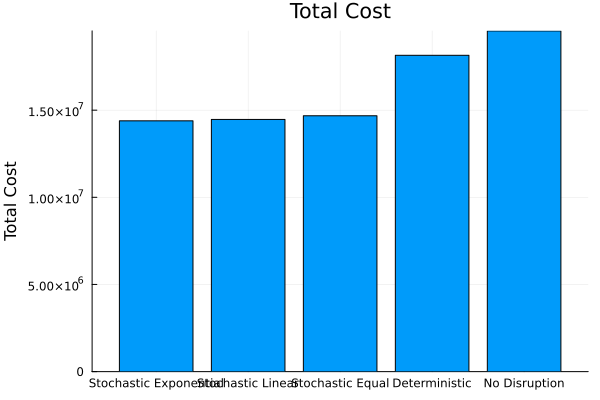

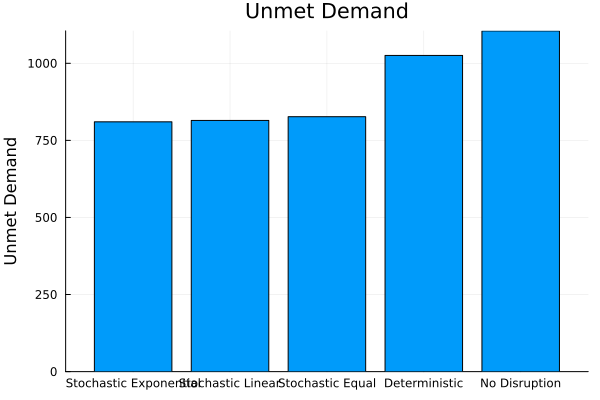

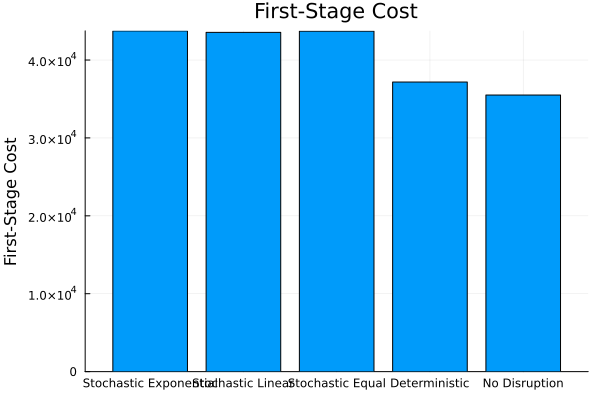

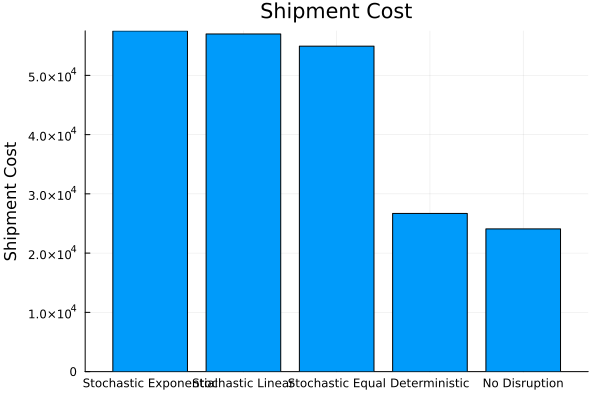

4-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing

In [34]:
using Plots, Statistics

# ─────────────────────────────────────────────────────────────
# Input results (assumes you’ve run CV already)
# ─────────────────────────────────────────────────────────────
res_all = [res_exp, res_lin, res_eq, res_det, res_nod]
labels  = ["Stochastic Exponential", "Stochastic Linear", "Stochastic Equal", "Deterministic", "No Disruption"]
metrics = [:total, :unmet_qty, :first, :ship]
titles  = ["Total Cost", "Unmet Demand", "First-Stage Cost", "Shipment Cost"]

# ─────────────────────────────────────────────────────────────
# Helper: get average of a field
# ─────────────────────────────────────────────────────────────
function avg_metric(results::Vector{NamedTuple}, field::Symbol)
    return mean(getfield.(results, field))
end

# ─────────────────────────────────────────────────────────────
# Plotting function for bar chart
# ─────────────────────────────────────────────────────────────
function plot_bar_metric(metric::Symbol, title_str::String)
    avgs = [avg_metric(r, metric) for r in res_all]
    bar(labels, avgs, legend=false, ylabel=title_str, title=title_str, 
#         yscale=:log10
    )
end

# ─────────────────────────────────────────────────────────────
# Generate bar plots
# ─────────────────────────────────────────────────────────────
plots = [plot_bar_metric(metrics[i], titles[i]) for i in 1:4]
display.(plots)

In [35]:
metrics

4-element Vector{Symbol}:
 :total
 :unmet_qty
 :first
 :ship

In [39]:
for metric in metrics
    avgs = [avg_metric(r, metric) for r in res_all]
    print("Metric: ")
    print(metric)
    print(" ")
    println(avgs)
end

Metric: total [1.4387687730102165e7, 1.446724108153857e7, 1.4676859834299348e7, 1.8148096722437754e7, 1.95486888419449e7]
Metric: unmet_qty [810.1340222468926, 814.6859408140682, 826.6802418883148, 1025.493601492001, 1105.1588628714694]
Metric: first [43743.14525687442, 43550.24702661589, 43707.26520733994, 37174.635969776056, 35506.20115430239]
Metric: ship [57509.0512563582, 56983.77870779952, 54930.12896609794, 26694.260570616985, 24085.26280642204]
